# Flavours of parallelism plus multithreading using the MKL

Covers: - multithreaded linear algebra with Numpy+MKL (easy win)

* ?

SPEEDING THINGS UP:
- USED TO HAVE UPWARD TREND IN SPEED AT WHICH PROCESSORS COULD PROCESS INSTRUCTIONS ('CLOCK SPEED')
- LITTLE IMPROVEMENT IN THIS 'CLOCK SPEED' IN RECENT YEARS.
- SO HOW CAN WE MAKE OUR CODE GO FASTER?  CAN'T BUY SIGNIFICANTLY FASTER PROCESSOR FOR LOVE NOR MONEY.
- ONE APPROACH IS TO DO MULTIPLE CHUNKS OF WORK AT ONCE.  
  - DISTRIBUTE WORK BETWEEN PROCESSING CORES OF ONE OR MORE CPUS IN ONE MACHINE
  - DISTRIBUTE WORK BETWEEN CPU CORES IN MULTIPLE MACHINES

TYPES OF PARALLELISM 
- SHARED MEM VS DISTRIBUTED MEM (DIAGS)
- SHARED MEM: SINGLE PROC, MULT THREADS, SINGLE GLOBAL ADDRESS SPACE.  ONE NODE.
- DISTR MEM: MULT PROC, EACH HAS ONE (OR MORE?) THREADS, ADDRESS SPACE PER PROCESSOR, ONE OR MORE NODES.  PROCS COMMUNICATE BY PASSING MESSAGES WITHIN MACHINE / BETWEEN MACHINES.
- PYTHON CAN ONLY EFFICIENTLY HANDLE DISTRIBUTED MEM PARALLELISATION AS TWO PYTHON THREADS CANNOT DO COMPUTATION AT THE SAME TIME DUE TO DESIGN OF PYTHON INTERPRETER. 

EASE OF PARALLELISING PROBLEMS
- SIMPLEST IF PARALLEL TASKS ARE INDEPENDENT (NO COMMUNICATION BETWEEN TASKS WHILST RUNNING) - EMBARASSINGLY PARALLEL
- THINGS GET MORE COMPLEX IF TASKS NEED TO COMMUNICATE.  NATURE OF COMPLEXITY DIFFERS FOR SM VS DM. 



FMA AND AVX2
https://github.com/workhorsy/py-cpuinfo

---


NB APOLOGIES IF YOU DON'T DO MUCH WORK WITH ARRAYS/MATRICES - FOLLOWING MAY NOT BE OF INTEREST!

## Using multiple threads to parallelise linear algebra operations

Such operations are so important in computing that decades of research has gone into:

1. Finding the most efficient algorithms for solving them;
2. Developing the most efficient software implementations of those algorithms (usually written in [C][c] or [Fortran][fortran]);
3. Adding features to processors to help accelerate these operations (**MORE ON THIS LATER**)

For this reason you need a *very* good reason to write your own linear algebra functions.

The standard way to do linear algebra in software is to use one of the several heavily optimised [software libraries][soft-lib] that implement
these specifications:

* [BLAS][blas] (*Basic Linear Algebra Subprograms*) - fundamental linear algebra functions;
* [LAPACK][lapack] (*Linear Algebra Package*) - higher-level linear algebra functions that use BLAS functions.

One of the most efficient BLAS/LAPACK implementations is provided by the Intel Math Kernel Library ([MKL][mkl]),
which includes linear algebra functions that can make use of both **shared memory parallelism** (**EXPLAINED BY HERE**)
and particular accelerating functionality built into certain Intel processors (see 3. above). (**COME BACK TO**)

The 'native' way to use the MKL is to write C or Fortran code but
for Python programmers simplest approach is to use a version of the [numpy][numpy] Python package built so
it uses the MKL behind the scenes for linear algebra functionality
(plus other functionality such as [fast Fourier transforms][fft]).

Whether or not numpy comes with MKL support largely depends on how it was installed:

* numpy installed using conda (e.g. with [Miniconda or Anaconda][mini-ana-conda]) has MKL support and installs the MKL as a dependency
  (NB need to install from the default or Intel Python Distribution conda channel);
* numpy installed using pip doesn't.

**Let's see if we can use numpy and the MKL to execute a matrix multiplication operation in parallel using more than one CPU core.**

First, although we are confident that our numpy has MKL support as we installed it with conda, let's double check.
We'll also import some modules that we'll use later on this lesson.

[blas]: https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms
[c]: https://en.wikipedia.org/wiki/C_(programming_language)
[dot-prod]: https://en.wikipedia.org/wiki/Dot_product
[fortran]: https://en.wikipedia.org/wiki/Fortran
[lapack]: https://en.wikipedia.org/wiki/LAPACK
[lin-alg]: https://en.wikipedia.org/wiki/Linear_algebra
[matr-mult-par]: https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Parallel_and_distributed_algorithms
[matr-mult]: https://en.wikipedia.org/wiki/Matrix_multiplication
[mkl]: https://software.intel.com/en-us/mkl
[numpy]: http://www.numpy.org/
[soft-lib]: https://en.wikipedia.org/wiki/Library_(computing)
[svd]: https://en.wikipedia.org/wiki/Singular-value_decomposition
[sys-lin-eq]: https://en.wikipedia.org/wiki/System_of_linear_equations
[fft]: https://en.wikipedia.org/wiki/Fast_Fourier_transform
[conda]: https://conda.io/
[mini-ana-conda]: https://conda.io/docs/user-guide/install/download.html

In [32]:
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import mkl  # provided by mkl-service package

plt.style.use('ggplot')
%matplotlib inline

np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/will/miniconda3/envs/hi-perf-ipynb/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/will/

If `mkl_rt` is listed as a `library` under `blas_opt_info` and `lapack_opt_info` then the MKL is used for BLAS and LAPACK functionality.
Alternatively, If you installed numpy using pip then other BLAS/LAPACK library/libraries may be listed instead (e.g. `openblas`).

---

Next, let's create two square matrices:

In [33]:
x = np.random.random_sample((1000, 1000))
y = np.random.random_sample((1000, 1000))
x[:5, :5]

array([[0.10852389, 0.78013701, 0.40242437, 0.33100978, 0.88375217],
       [0.54986889, 0.12802015, 0.68657152, 0.33058848, 0.22549879],
       [0.19439428, 0.3673249 , 0.23233952, 0.61094585, 0.31930015],
       [0.61169245, 0.64461447, 0.36573259, 0.54289866, 0.19878048],
       [0.52186317, 0.44607801, 0.26563295, 0.33378038, 0.05909986]])

We can then multiply these matrices using the new `@` operator (introduced in Python 3.5):

In [34]:
x @ y

array([[255.05436702, 252.62449521, 250.03866232, ..., 254.56227871,
        255.66873601, 240.72089114],
       [244.67932133, 246.9223243 , 249.47304416, ..., 251.34659014,
        247.52641989, 241.18552769],
       [257.55237051, 255.78370817, 257.3642714 , ..., 262.9881522 ,
        262.63040525, 248.62434195],
       ...,
       [252.31227987, 259.96374171, 249.10790623, ..., 260.45781556,
        257.06440439, 241.54022881],
       [242.42690323, 248.76081849, 244.26572835, ..., 253.67175188,
        256.19602987, 241.49960286],
       [244.35847696, 249.20929018, 242.00896396, ..., 252.25497593,
        251.88953231, 236.51146983]])

Note that we haven't told numpy/MKL *how* to execute the matrix multiplication.
By default the MKL intelligently and silently detects:

* how many CPU cores are available in the machine;
* how many threads (parallel strands of execution) it could *efficiently* use for executing operation(s) in parallel (where #threads <= #cores to ensure all threads can run at once); 
* whether the CPU(s) in the machine have features that optionally can be used to accelerate the operation(s). 

In [35]:
mkl.set_num_threads?

Let's look at what happens to the runtime of the matrix multiplication if we explicitly restrict the number of threads the MKL can create/use to 1, 2, 3 then 4 threads:

In [36]:
thread_cnts = np.arange(1, 5)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -o x @ y
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

40.8 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.9 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.6 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Here we use the [timeit](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) IPython 'magic' function to execute a Python statement multiple times and take the mean and standard deviation of those executions.

Let's plot the results

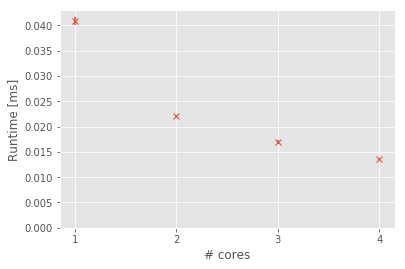

In [49]:
fig, ax = plt.subplots()
ax.errorbar(thread_cnts, timings_mean, yerr=timings_stdev, fmt='x')
ax.set_xticks(thread_cnts)
ax.set_xticklabels(thread_cnts)
ax.set_xlabel('# cores')
ax.set_ylabel('Runtime [ms]');
ax.set_ylim(ymin=0);

NOT LINEAR SPEEDUP WHEN INCREASE CORES

AHMDAHL'S LAW

NEED TO DECIDE FOR YOURSELF WHETHER USING MORE CORES IS WORTH IT.

RUN TESTS LIKE THE ABOVE WITH SUBSET OF PROGRAM TO SEE HOW THE PROBLEM SCALES TO MORE CORES

---
OTHER LIBRARIES CAN USE MKL TOO, EITHER BY DEPENDING ON NUMPY OR BY USING MKL DIRECTLY E.G. SCIPY

In [16]:
z = np.random.random_sample((1000, 80))

thread_cnts = np.arange(1, 5)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -n1  -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

23.5 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.2 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.4 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.8 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


BEST TO USE UP TO AS MANY THREADS AS AVAILABLE CPU CORES: USE MORE THAN THAT AND SOME THREADS WILL BE FORCED TO SPEND SOME TIME WAITING, WHICH IS INEFFICIENT USE OF CORES

In [17]:
z = np.random.random_sample((1000, 80))

thread_cnts = np.arange(1, 16, 4)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -n1 -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

22.3 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 ms ± 66.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.5 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


WHY NOT USE ALWAYS USE AS MANY THREADS AS AVAILABLE CORES?  SOMETIMES MAY WANT TO LIMIT MKL THREADS SO CAN HAVE MULTIPLE PROCESSES RUNNING AT ONCE THAT DON'T INTERFERE WITH EACH OTHER. (DIAG)